In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from othello.OthelloGame import OthelloGame as Game
from othello.OthelloGame import display as displayGame

import numpy as np

In [3]:
from othello_viz import display_board, plot_episode
from othello_reinforce_helper import display_results, play_with_model, play_episode, get_policy_model_softmax_cnn_deep, get_value_model_cnn_deep, get_discounted_rewards

Using TensorFlow backend.


In [4]:
# Defino juego
n = 6
game = Game(n)
board = game.getInitBoard()

In [5]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Concatenate, BatchNormalization, Activation, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.initializers import glorot_uniform
from keras.losses import categorical_crossentropy, binary_crossentropy


In [47]:
def one_cnn_6x6(lr = 0.001, ce_w=1, mse_w=1, input_shape = [6, 6, 1], do = 0.25):
    output_shape = input_shape[0]*input_shape[1]
    model = Sequential()
    model.add(Conv2D(16, 2, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, 2, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 2, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, 2, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, 2, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(do))

    inp = Input(input_shape)
    x = model(inp)
    x_value = Dense(1, name='value')(x)
    x_policy = Dense(output_shape, activation='softmax', name='policy')(x)
    full_model = Model(inp, [x_value, x_policy])

    full_model.compile(Adam(lr), loss={'policy': 'categorical_crossentropy', 'value': 'mse'}, 
                       loss_weights={'policy': ce_w, 'value': mse_w})
    return full_model
model = one_cnn_6x6(lr = 0.001)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 6, 6, 1)      0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 256)          176128      input_7[0][0]                    
__________________________________________________________________________________________________
value (Dense)                   (None, 1)            257         sequential_7[1][0]               
__________________________________________________________________________________________________
policy (Dense)                  (None, 36)           9252        sequential_7[1][0]               
Total params: 185,637
Trainable params: 184,645
Non-trainable params: 992
__________________

In [49]:
def paper_cnn(lr=0.001, filters=512, filter_size=3, do=0.3, input_shape = [6, 6, 1], ce_w=1, mse_w=1):
    output_shape = input_shape[0]*input_shape[1]
    inp = Input(input_shape)    
    x = Activation('relu')(BatchNormalization(axis=3)(Conv2D(filters, filter_size, padding='same', use_bias=False)(inp)))         # batch_size  x board_x x board_y x num_channels
    x = Activation('relu')(BatchNormalization(axis=3)(Conv2D(filters, filter_size, padding='same', use_bias=False)(x)))         # batch_size  x board_x x board_y x num_channels
    x = Activation('relu')(BatchNormalization(axis=3)(Conv2D(filters, filter_size, padding='valid', use_bias=False)(x)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
    x = Activation('relu')(BatchNormalization(axis=3)(Conv2D(filters, filter_size, padding='valid', use_bias=False)(x)))        # batch_size  x (board_x-4) x (board_y-4) x num_channels
    x = Flatten()(x)       
    x = Dropout(do)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024, use_bias=False)(x))))  # batch_size x 1024
    x = Dropout(do)(Activation('relu')(BatchNormalization(axis=1)(Dense(512, use_bias=False)(x))))          # batch_size x 1024
    v = Dense(1, activation='tanh', name='value')(x)                    # batch_size x 1
    pi = Dense(output_shape, activation='softmax', name='policy')(x)   # batch_size x self.action_size


    model = Model(inputs=inp, outputs=[v, pi])
    model.compile(loss=['mean_squared_error', 'categorical_crossentropy'], optimizer=Adam(lr), 
                  loss_weights=[ mse_w, ce_w])
    return model

In [50]:
model = paper_cnn()

In [51]:
from othello_reinforce_helper import play_with_full_model, play_episode_with_value

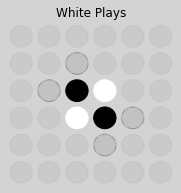

In [52]:
player = 1
display_board(game, board, player, valid_moves=game.getValidMoves(board, player))

In [53]:
# Juego episodio
player = 1
# La razon por la que le paso board*player es para que la posición de comienzo sea la misma siempre
states, actions, rewards, values, predictions = play_episode_with_value(
    [lambda game, board, return_predictions: play_with_full_model(model, game, board, conv=True, return_predictions=return_predictions), 
     lambda game, board, return_predictions: play_with_full_model(model, game, board, conv=True, return_predictions=return_predictions)], 
    game, board*player, return_actions=True, return_predictions=True, append_last=True)
print('longitud episodio:', len(states))

longitud episodio: 34


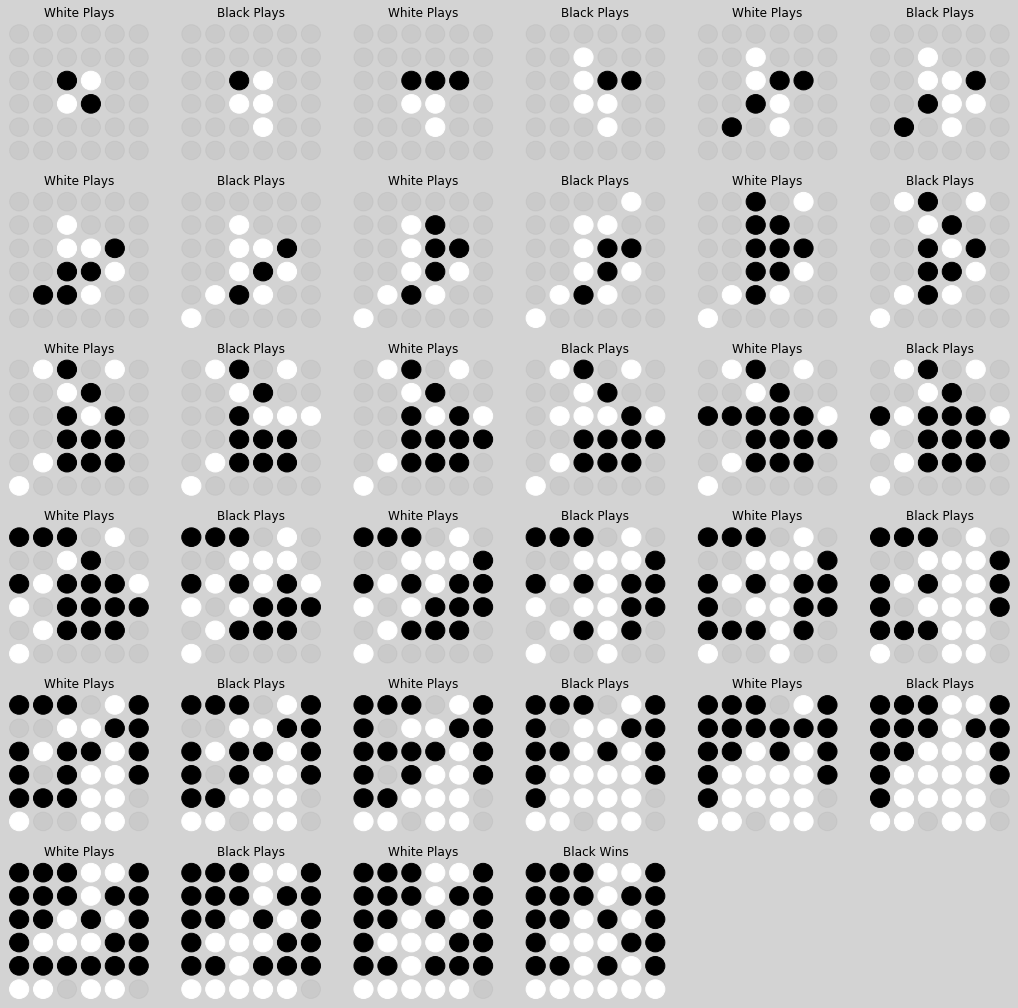

In [54]:
# Grafico episodio
plot_episode(game, states, initial_player = player)

### Interpretación del discounted reward en este caso (Juegos):
- Siempre empieza jugando blanco. Por eso si pierde blanco, el primer discounted reward (último empezando de atras) tiene que ser negativo
- Siempre se alterna (Si no hay movida eso se considera un paso mas). Esto es para asegurar que se puede multiplicar por -1 para el cálculo del discounted reward
- Si el flag de append_last esta en true, tenerlo en cuanta al analizar el último reward (El primero contando de atras)

In [55]:
# Para entender esto bien 
discounted_rewards = get_discounted_rewards(rewards)
print(discounted_rewards)

[-0.72498034  0.73230337 -0.73970037  0.74717209 -0.75471929  0.76234271
 -0.77004315  0.77782136 -0.78567814  0.79361428 -0.80163059  0.80972787
 -0.81790694  0.82616862 -0.83451376  0.84294319 -0.85145777  0.86005835
 -0.86874581  0.87752102 -0.88638487  0.89533825 -0.90438208  0.91351725
 -0.92274469  0.93206535 -0.94148015  0.95099005 -0.96059601  0.970299
 -0.9801      0.99       -1.        ]


In [56]:
states_fl = np.array(states).reshape(-1, 36)
for i in range(len(rewards)):
    turn = ['w', 'b'][i%2]
    print(f'juega {turn} con tablero: {states_fl[i]} dada accion: {actions[i]} se evalua: {discounted_rewards[i]}, {rewards[i]}')

juega w con tablero: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  1  0  0  0  0  1 -1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] dada accion: 27 se evalua: -0.7249803359578534, 0
juega b con tablero: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0 -1 -1  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0] dada accion: 16 se evalua: 0.7323033696543974, 0
juega w con tablero: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  1  1  0  0
  0  0  0  1  0  0  0  0  0  0  0  0] dada accion: 8 se evalua: -0.7397003733882802, 0
juega b con tablero: [ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  1  1  0  0  0 -1 -1  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0] dada accion: 25 se evalua: 0.7471720943315961, 0
juega w con tablero: [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  1 -1 -1  0  0  0 -1  1  0  0
  0 -1  0  1  0  0  0  0  0  0  0  0] dada accion: 22 se evalua: -0.7547192872036325, 0
juega b con tablero: [ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1 -1  1  0  0  0  1 -1 -1  0

In [57]:
states.shape, actions.shape, discounted_rewards.shape

((34, 6, 6), (33,), (33,))

# Evaluate

In [58]:
from playing_stats import EvaluatePolicy
evalPolicy = EvaluatePolicy(None)

In [59]:
def evaluate_training_full(model, episodes = 100, conv=False, player=None, exploit=False):
    def play_with_mod(model, game, board, conv=conv, exploit=exploit):
        action, value = play_with_full_model(model, game, board, conv=conv, exploit=exploit)
        return action
    if player is None:
        player = evalPolicy.random_player
    player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                    board, 
                                                    {1: player, 
                                                     -1: lambda game, board: play_with_mod(model, game, board, conv=conv, exploit=exploit)}, 
                                                    episodes)
    porc = 100.0*player_2_wins/episodes
    return porc

In [60]:
print(evaluate_training_full(model, conv=True, player=None))
print(evaluate_training_full(model, conv=True, player=evalPolicy.greedy_player))

48.0
42.0


In [61]:
value, predictions = model.predict(board.reshape(1, 6, 6, 1))

In [62]:
value.shape, predictions.shape

((1, 1), (1, 36))

# Train

# Una sola red neuronal

In [63]:
from keras.utils import to_categorical

In [70]:
def play_episodes(model, game, board, episodes=1, conv=True, return_predictions=True, player=1):
    states_ = []
    actions_ = []
    rewards_ = []
    predictions_ = []
    discounted_rewards_preds_ = []
    for i in range(episodes):
        states, actions, rewards, discounted_rewards_preds, predictions = play_episode_with_value(
            [lambda game, board, return_predictions: play_with_full_model(model, game, board, conv=conv, return_predictions=return_predictions), 
             lambda game, board, return_predictions: play_with_full_model(model, game, board, conv=conv, return_predictions=return_predictions)], 
            game, board*player, return_actions=True, return_predictions=True)
        states_.append(states)
        actions_.append(actions.reshape(-1, 1))
        rewards_.append(rewards.reshape(-1, 1))
        discounted_rewards_preds_.append(discounted_rewards_preds.reshape(-1, 1))
        predictions_.append(predictions)
    return np.vstack(states_), np.vstack(actions_), np.vstack(rewards_), np.vstack(discounted_rewards_preds_), np.vstack(predictions_)

In [74]:
states.shape

(1280, 6, 6)

In [ ]:
n_square = game.n**2
dropout = 0.0
batch_size = 32
model = one_cnn_6x6(lr=0.001, do=dropout)
# model = paper_cnn(lr=0.001, do=dropout)
epsilon = 1e-12
losses = []
value_losses = []
policy_losses = []
episodes = 20_000
eval_period = 100
conv = True
discounted_rewards_preds=None
for episode in range(episodes):       
    states, actions, rewards, discounted_rewards_preds, predictions = play_episodes(model, game, board, episodes=2)
    
    discounted_rewards = get_discounted_rewards(rewards)
    no_move_indexes = (actions != n_square).flatten()
    states = states[no_move_indexes]
    actions = actions[no_move_indexes].reshape(-1, 1)
    discounted_rewards = discounted_rewards[no_move_indexes].reshape(-1, 1)
    discounted_rewards_preds = discounted_rewards_preds[no_move_indexes].reshape(-1, 1)
    
    # Augmentation
    states = np.vstack([states, np.flip(states, axis=[2]), np.flip(states, axis=[1]), np.rot90(states, axes=(1, 2))])
    actions = np.vstack([actions, actions, actions, actions])
    discounted_rewards = np.vstack([discounted_rewards, discounted_rewards, discounted_rewards, discounted_rewards])
    discounted_rewards_preds = np.vstack([discounted_rewards_preds, discounted_rewards_preds, discounted_rewards_preds, discounted_rewards_preds])
    

    x_train = states.reshape(-1, *board.shape, 1)
    
    y_train = to_categorical(actions, n_square)*(discounted_rewards - discounted_rewards_preds)

    hist = model.fit(x_train, [discounted_rewards, y_train], epochs=1, verbose=0, batch_size=batch_size)
    value_losses.append(hist.history['value_loss'][-1])    
    policy_losses.append(hist.history['policy_loss'][-1])
    losses.append(hist.history['loss'][-1])
    
    if episode%eval_period == 0:
        entropy = np.mean(-np.sum(np.log(predictions+epsilon)*predictions, axis=1)/np.log(n_square))
        print(f'episode: {episode}, entropy={entropy}, loss={np.mean(losses[-eval_period:])}, policy_loss={np.mean(policy_losses[-eval_period:])}, value_loss={np.mean(value_losses[-eval_period:])}')
        rand_sec = evaluate_training_full(model, episodes=100, conv=conv, player=evalPolicy.random_player)
        pol_sec = evaluate_training_full(model, episodes=100, conv=conv, player=evalPolicy.greedy_player)
        rand_sec_ex = evaluate_training_full(model, episodes=100, conv=conv, player=evalPolicy.random_player, exploit=True)
        pol_sec_ex = evaluate_training_full(model, episodes=100, conv=conv, player=evalPolicy.greedy_player, exploit=True)
        print(f'Como segundo contra random_player (explore|exploit): {rand_sec} | {rand_sec_ex}')
        print(f'Como segundo contra greedy player (explore|exploit): {pol_sec} | {pol_sec_ex}')
        print()
        if (rand_sec_ex == 100) and (pol_sec_ex == 100):
            print('Evaluando con 2000 episodios ...')
            rand_sec_ex = evaluate_training_full(model, episodes=2000, conv=conv, player=evalPolicy.random_player, exploit=True)
            print(rand_sec_ex)
            if rand_sec_ex == 100:
                break

episode: 0, entropy=0.9998973608016968, loss=1.1613064408302307, policy_loss=-0.03995184041559696, value_loss=1.2012582868337631
Como segundo contra random_player (explore|exploit): 62.0 | 67.0
Como segundo contra greedy player (explore|exploit): 44.0 | 51.0

episode: 100, entropy=0.35730788111686707, loss=0.4554738084780963, policy_loss=-0.15118583328267465, value_loss=0.606659640995842
Como segundo contra random_player (explore|exploit): 78.0 | 73.0
Como segundo contra greedy player (explore|exploit): 66.0 | 72.0

episode: 200, entropy=0.4095434248447418, loss=0.18827732380006523, policy_loss=-0.36510103610506844, value_loss=0.5533783579156513
Como segundo contra random_player (explore|exploit): 79.0 | 80.0
Como segundo contra greedy player (explore|exploit): 75.0 | 61.0

episode: 300, entropy=0.4567617177963257, loss=0.4640992024825734, policy_loss=-0.07109427143269921, value_loss=0.5351934737289752
Como segundo contra random_player (explore|exploit): 79.0 | 83.0
Como segundo contra